In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb

import random
from collections import Counter, defaultdict

from sklearn.model_selection import GroupKFold

In [2]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    np.random.seed(seed)
    # ラベルの数をカウント
    labels_num = np.max(y) + 1
    # 各グループのラベルの数をカウントする
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1
    # 各フォールドのラベルの数をカウント
    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)

    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)

    for i in range(k):
        test_k = i
        train_groups = all_groups - groups_per_fold[test_k]  #  - groups_per_fold[val_k]
        test_groups = groups_per_fold[test_k]

        def choice_ind(group):
            indices = []
            n_g = None
            list_ = []
            for i, g in enumerate(groups):
                if g in group:
                    if n_g is not None and n_g != g:
                        indices.append(list_)
                        list_ = []
                    list_.append(i)
                    n_g = g

            indices = [np.random.choice(i) for i in indices]
            return indices

        train_indices = choice_ind(train_groups)
        test_indices = choice_ind(test_groups)
        # print(train_indices)
        yield train_indices, test_indices  # val_indices,

In [30]:
train_path = '/code/data/transformation/trans_train.csv'
test_path = '/code/data/transformation/trans_test.csv'

train = pd.read_csv(train_path, index_col=0)
test = pd.read_csv(test_path, index_col=0)

In [31]:
train

,session_title,accuracy_group,installation_id,game_mean_event_count,accumulated_game_miss,mean_game_round,max_game_round,good_comment,coordinates,count_action_label,...,label_ACC_NO_lank0_hour_lank2,count_label_ACC_NO_lank0_hour_lank2,label_session_title_hour_lank1,count_label_session_title_hour_lank1,label_dayofweek_lank0_non_zero_info,count_label_dayofweek_lank0_non_zero_info,label_count_accuracy_label_info_lank0,count_label_count_accuracy_label_info_lank0,label_frequency_label_EVENT_CODE_LIST_lank4,count_label_frequency_label_EVENT_CODE_LIST_lank4
0,0,3,0006a69f,65.437500,12,5.000000,15,54,0,6,...,0,1458,18,40,12,817,1,1353,70,440
1,41,0,0006a69f,91.859375,13,4.166667,15,56,0,7,...,66,1385,90,33,11,1030,24,1015,97,449
2,0,3,0006a69f,91.859375,13,4.166667,15,56,0,7,...,0,1458,18,40,11,1030,14,2894,97,449
3,0,2,0006a69f,74.866211,16,4.000000,15,106,0,7,...,12,910,8,235,11,1030,14,2894,5,2763
4,41,3,0006a69f,98.983276,18,3.923077,15,116,0,7,...,8,316,84,162,11,1030,14,2894,5,2763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17685,22,3,ffc90c32,92.118164,10,4.363636,9,74,0,7,...,66,1385,61,299,12,817,19,1577,32,860
17686,43,3,ffd2871d,93.375000,5,3.000000,4,90,0,6,...,13,2393,107,166,21,929,5,826,97,449
17687,43,1,ffeb0b1b,40.875000,14,4.000000,15,106,0,6,...,0,1458,102,221,60,310,0,271,15,176
17688,0,0,ffeb0b1b,120.968750,24,4.333333,15,126,0,7,...,35,28,6,208,59,901,7,15,12,291


In [32]:
train['target'] = 0
test['target'] = 1

In [33]:
train = train.sample(1000)

In [34]:
train_df = pd.concat([train, test]).reset_index(drop=True)
train_df.columns = train_df.columns.str.replace(',', '')

In [35]:
y = train_df['target']
x = train_df.drop('target', axis=1)
groups = np.array(x['installation_id'])
lgb_params = {
        'objective': 'binary',
        'metric': 'auc',
    }
x = x.drop(['accuracy_group', 'installation_id'], axis=1)

In [39]:
x = x.drop('mean_accuracy_group_label', axis=1) 

In [40]:
from sklearn.model_selection import KFold

def lgb_regression(x, y, groups, lgb_params) -> pd.DataFrame:

    num_fold = 3
    pred = np.zeros(y.shape)
    all_importance = []

    for fold_ind, (train_ind, test_ind) in enumerate(
            stratified_group_k_fold(X=x, y=y, groups=groups, k=num_fold, seed=77)):
        print(train_ind)
        print(test_ind)
        x_train = x.iloc[train_ind]
        y_train = y.iloc[train_ind]
        x_test = x.iloc[test_ind]
        y_test = y.iloc[test_ind]
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_val = lgb.Dataset(x_test, y_test, reference=lgb_train)

        model = lgb.train(params=lgb_params,
                          train_set=lgb_train,
                          valid_sets=lgb_val)

        pred[test_ind] = model.predict(x_test, num_iteration=model.best_iteration)

        all_importance.append(pd.DataFrame(model.feature_importance('gain'), index=x_train.columns))

    all_importance = pd.concat(all_importance, axis=1)
    return pred, all_importance


In [41]:
pred, importance = lgb_regression(x, y, groups, lgb_params)

1, 183, 188, 189, 190, 191, 204, 210, 211, 213, 217, 218, 219, 230, 233, 234, 236, 238, 239, 240, 241, 246, 251, 254, 256, 260, 261, 265, 266, 268, 272, 273, 275, 278, 280, 282, 291, 295, 298, 303, 306, 308, 312, 316, 321, 328, 331, 337, 338, 340, 341, 344, 347, 352, 354, 362, 363, 364, 368, 371, 376, 378, 379, 381, 383, 386, 389, 390, 393, 395, 402, 403, 404, 405, 410, 417, 424, 425, 429, 438, 439, 440, 446, 450, 452, 459, 461, 463, 471, 473, 475, 476, 478, 480, 482, 483, 490, 496, 497, 498, 500, 503, 505, 509, 514, 526, 530, 531, 533, 534, 537, 539, 545, 546, 548, 553, 556, 557, 559, 561, 564, 565, 568, 571, 574, 576, 578, 579, 581, 584, 588, 593, 595, 597, 600, 603, 604, 614, 621, 622, 624, 627, 628, 632, 633, 635, 638, 641, 648, 649, 652, 653, 654, 659, 660, 662, 672, 673, 674, 677, 678, 680, 683, 685, 688, 689, 701, 704, 705, 709, 712, 714, 717, 718, 720, 729, 732, 734, 735, 740, 742, 744, 746, 748, 749, 750, 752, 758, 761, 762, 764, 767, 771, 772, 774, 775, 784, 785, 786, 788, 79

In [42]:
importance.mean(axis=1).sort_values(ascending=False).head(20)

label_count_accuracy_label_info_lank0          568.266578
label_frequency_label_EVENT_CODE_LIST_lank4    345.572577
ratio_Clip                                     250.500074
count_label_ACC_NO_lank0_hour_lank2            245.353452
event_id_lank1                                 220.762669
event_id_lank3                                 216.385832
TITLE_LIST_lank2                               211.573463
non_zero_hour                                  210.910987
game_mean_event_count                          209.285710
event_id_lank2                                 207.308078
count_label_session_title_hour_lank1           205.633627
event_id_lank4                                 203.078963
ratio_Game                                     202.023243
hour_lank0                                     198.053819
ratio_Activity                                 187.362418
mean_game_round                                181.226608
TITLE_LIST_lank3                               176.166116
title_non_zero

/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


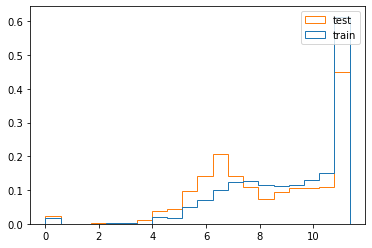

In [114]:
labels = ['train', 'test']
plt.hist([np.log1p(train['total_duration']), np.log1p(test['total_duration'])],normed=True, histtype="step", bins=20, label=labels)
plt.legend()

In [115]:
train['total_duration']

10928    33346
7538       820
14235      755
14636    59066
8642     64885
         ...  
10319     1646
7165        24
17327     1579
8610     65705
12598    81885
Name: total_duration, Length: 1000, dtype: int64

In [ ]:
count_correct_attempts      754.129082
total_duration              327.039930
count_uncorrect_attempts    297.834829

/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


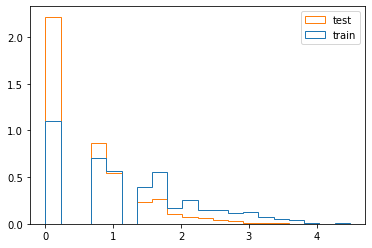

In [86]:
labels = ['train', 'test']
plt.hist([np.log1p(train['count_correct_attempts']), np.log1p(test['count_correct_attempts'])],normed=True, histtype="step", bins=20, label=labels)
plt.legend()

/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


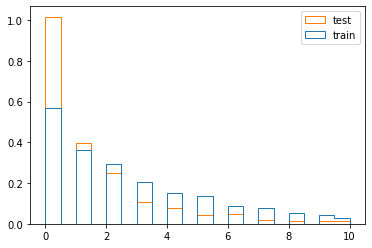

In [90]:
labels = ['train', 'test']
plt.hist([train['count_correct_attempts'], test['count_correct_attempts']],normed=True, histtype="step", bins=20, label=labels, range=(0, 10))
plt.legend()

/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


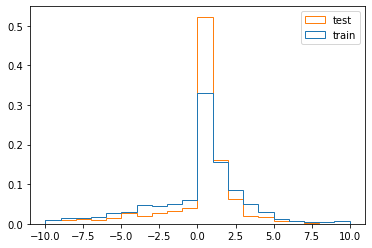

In [93]:
labels = ['train', 'test']
plt.hist([train['count_correct_attempts']-train['count_uncorrect_attempts'], test['count_correct_attempts']-test['count_uncorrect_attempts']],normed=True, histtype="step", bins=20, label=labels, range=(-10, 10))
plt.legend()

In [99]:
train_dif = train['count_correct_attempts']-train['count_uncorrect_attempts']
test_dif = test['count_correct_attempts']-test['count_uncorrect_attempts']

In [112]:
train.query('count_correct_attempts == 0 and count_uncorrect_attempts==0')

,Clip,Activity,Game,session_title,count_correct_attempts,count_uncorrect_attempts,accuracy_group,installation_id,4050,total_duration,...,non_zero_info,info_lank0,info_lank1,info_lank2,label_session_title_count_action_label,label_session_title_count_accuracy_label,count_label_session_title_count_accuracy_label,label_session_title_mean_accuracy_group_label,count_label_session_title_mean_accuracy_group_label,target
14235,5,1,1,22,0,0,0,ca58d659,0,755,...,3,8,1,5,25,10,433,10,433,0
14636,6,0,3,10,0,0,3,d07024ee,0,59066,...,3,8,0,5,15,5,1173,5,1173,0
10803,3,3,0,43,0,0,1,972011af,0,7992,...,4,8,7,5,45,20,1307,20,1307,0
1596,7,1,2,10,0,0,0,1487877c,0,4250,...,3,8,1,5,15,5,1173,5,1173,0
8521,3,2,1,0,0,0,3,758bc502,0,516,...,3,1,8,7,5,0,1115,0,1115,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15398,4,2,3,43,0,0,1,db6503fa,0,1346,...,3,1,7,5,46,20,1307,20,1307,0
1377,5,1,2,10,0,0,0,12356ffe,0,388,...,3,7,5,4,14,5,1173,5,1173,0
3866,4,0,1,41,0,0,1,31f4e863,0,224,...,3,1,7,8,34,15,387,15,387,0
7768,6,3,1,10,0,0,1,6a5285db,0,340,...,3,1,5,7,15,5,1173,5,1173,0


In [113]:
test.query('count_correct_attempts == 0 and count_uncorrect_attempts==0')

,Clip,Activity,Game,session_title,count_correct_attempts,count_uncorrect_attempts,accuracy_group,installation_id,4050,total_duration,...,non_zero_info,info_lank0,info_lank1,info_lank2,label_session_title_count_action_label,label_session_title_count_accuracy_label,count_label_session_title_count_accuracy_label,label_session_title_mean_accuracy_group_label,count_label_session_title_mean_accuracy_group_label,target
2,6,2,0,0,0,0,0,017c5718,0,43439,...,5,1,5,8,5,0,1115,0,1115,1
3,10,2,1,0,0,0,0,01a44906,0,35737,...,2,1,5,8,5,0,1115,0,1115,1
4,17,1,6,10,0,0,0,01bc6cb6,0,10556,...,3,8,1,5,16,5,1173,5,1173,1
6,13,2,5,0,0,0,0,0267757a,0,10190,...,3,0,8,5,6,0,1115,0,1115,1
9,15,0,1,10,0,0,0,0300c576,0,764,...,5,1,3,4,13,5,1173,5,1173,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,2,2,0,43,0,0,0,f9dd0fe3,0,211,...,3,5,1,7,44,20,1307,20,1307,1
982,5,2,1,0,0,0,0,faa8c019,0,615,...,2,1,7,8,5,0,1115,0,1115,1
985,6,4,1,43,0,0,0,fbe1fea6,0,3376,...,1,8,5,7,45,20,1307,20,1307,1
987,33,15,18,0,0,0,0,fc5612b9,0,28012,...,1,5,1,8,8,0,1115,0,1115,1


In [61]:
x.drop(['acc_0', 'ratio_Assessment', 'frequency', 'Assessment', 'count_correct_attempts'], axis=1, inplace=True)

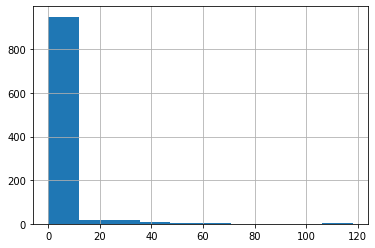

In [62]:
train['acc_0'].hist()

In [63]:
import matplotlib.pyplot as plt

/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


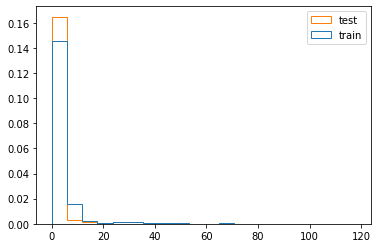

In [64]:
labels = ['train', 'test']
plt.hist([train['acc_0'], test['acc_0']],normed=True, histtype="step", bins=20, label=labels)
plt.legend()


/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


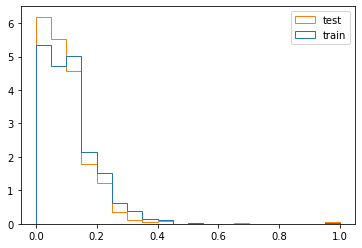

In [65]:
plt.hist([train['ratio_Assessment'], test['ratio_Assessment']],normed=True, histtype="step", bins=20, label=labels)
plt.legend()

/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


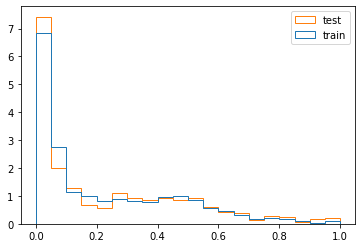

In [66]:
plt.hist([train['frequency'], test['frequency']],normed=True, histtype="step", bins=20, label=labels,range=(0,1))
plt.legend()

In [73]:
x.columns[x.columns.str.contains('info')]

Index(['info_2', 'info_8', 'info_9', 'info_6', 'info_1', 'info_3', 'info_0',
       'info_5', 'info_7', 'info_4'],
      dtype='object')

In [67]:
pred, importance = lgb_regression(x, y, groups, lgb_params)

 170, 173, 175, 185, 190, 191, 193, 198, 200, 202, 203, 204, 205, 208, 211, 212, 216, 221, 222, 224, 229, 235, 237, 244, 246, 251, 253, 258, 263, 265, 266, 267, 269, 270, 272, 275, 280, 282, 283, 287, 289, 292, 293, 294, 298, 302, 304, 313, 314, 316, 317, 319, 320, 326, 331, 347, 354, 355, 356, 361, 363, 365, 367, 370, 378, 382, 383, 390, 396, 397, 401, 403, 404, 410, 412, 417, 419, 424, 427, 429, 433, 434, 435, 438, 439, 445, 446, 447, 448, 449, 452, 454, 457, 461, 464, 465, 468, 472, 473, 474, 476, 485, 486, 487, 492, 496, 497, 502, 505, 509, 511, 512, 514, 516, 518, 523, 525, 528, 530, 534, 535, 539, 540, 543, 545, 550, 557, 561, 564, 565, 569, 574, 577, 580, 587, 588, 590, 591, 594, 601, 603, 605, 608, 612, 613, 614, 615, 617, 624, 626, 627, 630, 633, 635, 636, 638, 639, 642, 647, 650, 651, 652, 653, 656, 658, 659, 660, 666, 672, 674, 677, 678, 679, 684, 685, 687, 690, 692, 694, 697, 700, 704, 714, 717, 719, 727, 732, 737, 749, 750, 751, 753, 756, 758, 765, 767, 768, 769, 772, 775,

In [68]:
importance.mean(axis=1).sort_values(ascending=False)

count_uncorrect_attempts    496.488109
acc_3                       408.103410
total_duration              379.680217
ratio_event_code_3000       234.885558
non_zero_dayofweek          207.968127
                               ...    
count_accuracy_label          0.153268
coordinates                   0.000000
info_0                        0.000000
args_11                       0.000000
args_3                        0.000000
Length: 98, dtype: float64

In [69]:
x.drop(['count_uncorrect_attempts'], axis=1, inplace=True)

In [70]:
x

,Clip,Activity,Game,session_title,count_accuracy,acc_Mushroom Sorter (Assessment),acc_Chest Sorter (Assessment),acc_Bird Measurer (Assessment),acc_Cart Balancer (Assessment),acc_Cauldron Filler (Assessment),...,hour_lank1,hour_lank2,std_dayofweek_count,non_zero_dayofweek,dayofweek_lank0,label_session_title_count_action_label,label_session_title_count_accuracy_label,count_label_session_title_count_accuracy_label,label_session_title_mean_accuracy_group_label,count_label_session_title_mean_accuracy_group_label
0,24,3,3,22,0.750000,1.000000,-1.0,-1.0,0.5,-1.000000,...,23,0,153.397864,4,2,26,13,621,13,925
1,15,3,0,43,0.555556,0.000000,-1.0,-1.0,0.5,1.000000,...,1,19,119.532223,4,0,46,22,1256,22,1155
2,19,6,8,0,0.722222,1.000000,1.0,-1.0,1.0,1.000000,...,13,0,507.984252,6,5,7,3,516,3,870
3,264,20,50,43,0.142688,0.000000,0.0,0.0,0.0,0.333333,...,16,21,1321.910486,0,0,48,21,614,21,356
4,17,17,24,22,1.000000,-1.000000,1.0,-1.0,1.0,1.000000,...,1,4,801.781142,3,1,28,14,532,14,532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,4,0,1,43,0.666667,1.000000,-1.0,1.0,-1.0,-1.000000,...,18,0,51.834443,5,5,45,22,1256,23,870
1996,11,2,2,22,1.000000,-1.000000,-1.0,-1.0,1.0,-1.000000,...,21,0,91.510343,5,6,25,14,532,14,532
1997,32,2,0,10,0.583333,0.333333,0.0,-1.0,-1.0,1.000000,...,20,0,197.550837,5,0,16,7,1308,7,1163
1998,11,3,1,10,0.250000,-1.000000,-1.0,-1.0,-1.0,0.000000,...,0,21,88.195670,5,1,15,6,557,7,1163


In [71]:
pred, importance = lgb_regression(x, y, groups, lgb_params)

3, 175, 185, 190, 191, 193, 198, 200, 202, 203, 204, 205, 208, 211, 212, 216, 221, 222, 224, 229, 235, 237, 244, 246, 251, 253, 258, 263, 265, 266, 267, 269, 270, 272, 275, 280, 282, 283, 287, 289, 292, 293, 294, 298, 302, 304, 313, 314, 316, 317, 319, 320, 326, 331, 347, 354, 355, 356, 361, 363, 365, 367, 370, 378, 382, 383, 390, 396, 397, 401, 403, 404, 410, 412, 417, 419, 424, 427, 429, 433, 434, 435, 438, 439, 445, 446, 447, 448, 449, 452, 454, 457, 461, 464, 465, 468, 472, 473, 474, 476, 485, 486, 487, 492, 496, 497, 502, 505, 509, 511, 512, 514, 516, 518, 523, 525, 528, 530, 534, 535, 539, 540, 543, 545, 550, 557, 561, 564, 565, 569, 574, 577, 580, 587, 588, 590, 591, 594, 601, 603, 605, 608, 612, 613, 614, 615, 617, 624, 626, 627, 630, 633, 635, 636, 638, 639, 642, 647, 650, 651, 652, 653, 656, 658, 659, 660, 666, 672, 674, 677, 678, 679, 684, 685, 687, 690, 692, 694, 697, 700, 704, 714, 717, 719, 727, 732, 737, 749, 750, 751, 753, 756, 758, 765, 767, 768, 769, 772, 775, 776, 78

In [43]:
importance.mean(axis=1).sort_values(ascending=False)

acc_3                            402.387879
acc_Chest Sorter (Assessment)    282.623534
total_duration                   262.277113
ratio_event_code_4000            234.637282
non_zero_dayofweek               204.222307
                                    ...    
info_0                             0.000000
count_action_label                 0.000000
args_11                            0.000000
args_3                             0.000000
count_accuracy_label               0.000000
Length: 97, dtype: float64